# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [ ]:
oil_1 = pd.read_csv("/content/geo_data_0.csv")
oil_2 = pd.read_csv("/content/geo_data_1.csv")
oil_3 = pd.read_csv("/content/geo_data_2.csv")

Для начала импортируем необходимые нам библиотекм. Из условия задачи мы видим, что нам понадобятся Линейная Регрессия, MSE, рассчет доверительного интервала. Также загрузим данные по регионам, и выведем первые пять строк.

In [ ]:
display (oil_1.head())
print()
display (oil_2.head())
print()
display (oil_3.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Создадим функцию, которая проверит наличие пропусков в таблицах

In [ ]:
oils = [oil_1, oil_2, oil_3]
for oil in oils:
    report = oil.isna().sum().to_frame()
    report = report.rename(columns={0: 'missing_values'})
    report['% of total'] = (report['missing_values'] / oil.shape[0]).round(2)
    print (report.sort_values(by='missing_values', ascending=False))

         missing_values  % of total
id                    0         0.0
f0                    0         0.0
f1                    0         0.0
f2                    0         0.0
product               0         0.0
         missing_values  % of total
id                    0         0.0
f0                    0         0.0
f1                    0         0.0
f2                    0         0.0
product               0         0.0
         missing_values  % of total
id                    0         0.0
f0                    0         0.0
f1                    0         0.0
f2                    0         0.0
product               0         0.0


Пропуски отсутствуют, необходимо еще проверить, не повторяются ли id( уникальный идентификатор скважины ) в таблицах. 
Есть повторения, их крайне мало, поэтому можем удалить их из таблицы, изпользуя функцию и метод 'drop'

In [ ]:
oil_1['id'].duplicated().sum()

10

In [ ]:
oil_2['id'].duplicated().sum()

4

In [ ]:
oil_3['id'].duplicated().sum()

4

Перед тем как обучать модель, взглянем еще раз на наши данные. В первую очередь, создадим корреляционную матрицу, и проведем анализ факторов в каждом регионе.

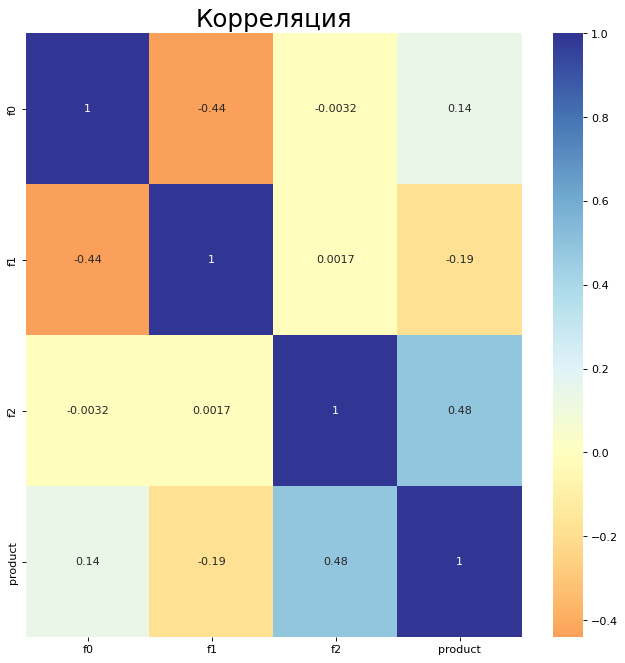

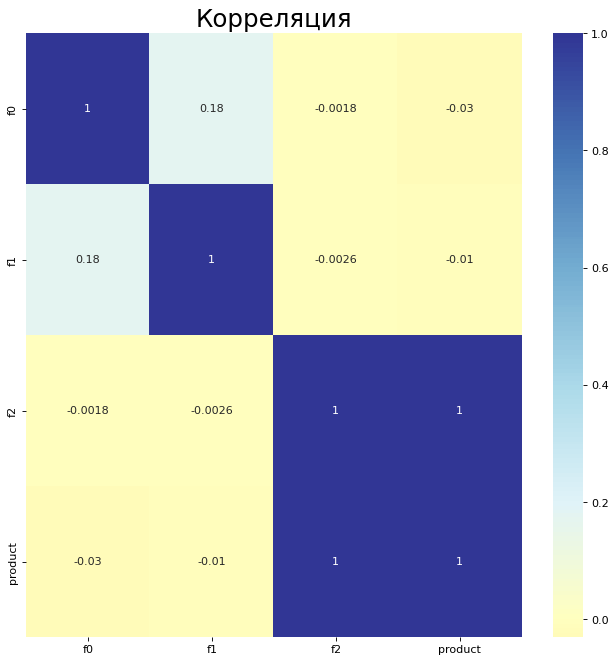

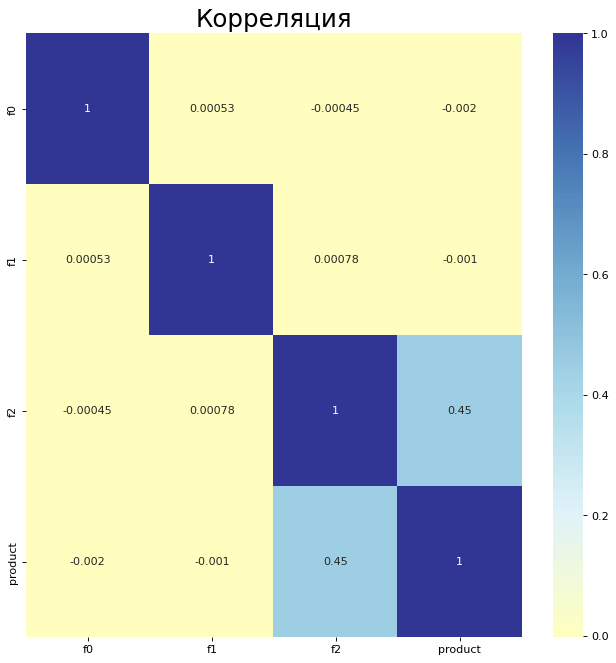

In [ ]:
for oil in oils:
    plt.figure(figsize = (10,10), dpi=80)
    sns.heatmap(oil[['id', 'f0', 'f1', 'f2', 'product'
       ]].corr(), xticklabels=oil[['id', 'f0', 'f1', 'f2', 'product'
       ]].corr().columns, yticklabels=oil[['id', 'f0', 'f1', 'f2', 'product'
       ]].corr().columns, cmap='RdYlBu', center=0, annot=True)
    plt.title('Корреляция', fontsize=22)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

Самое важное, что мы можем тут отметить: регион 2, где уровень корреляции между "f2"  и "product" равна 1. Позднее необходимо будет обратить внимание на метрики модели.
Напишем функцию, которая построит гистограмму с объемом запасов в скважине в каждом регионе.  

In [ ]:
def product_oil(seria, bins, xlim_max, ylim_max):
    plt.figure(figsize=[12,10])
    plt.hist(seria, bins=bins)
    plt.xlim([0,xlim_max])
    plt.ylim([0,ylim_max])
    plt.xlabel("Объем нефти на скважину")
    plt.ylabel("Кол-во скважин")
    plt.title("График распределения по объему скважин")
    plt.show()

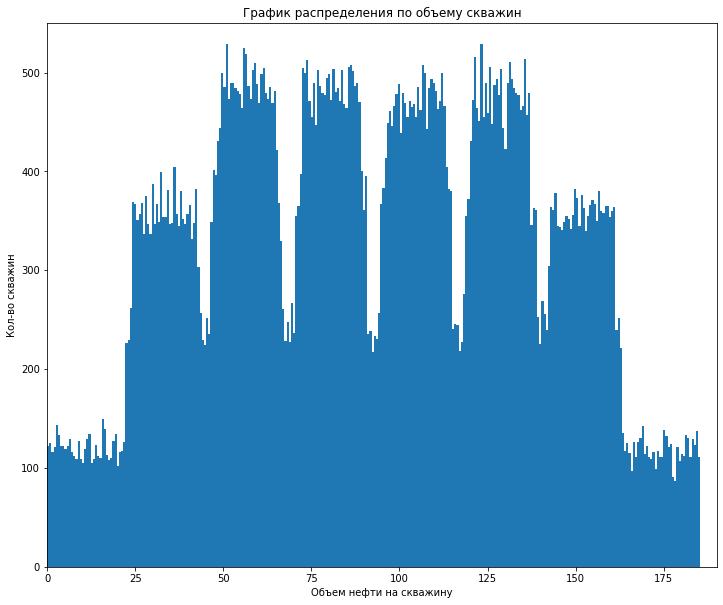

In [ ]:
product_oil(oil_1['product'], 300, 190, 550)

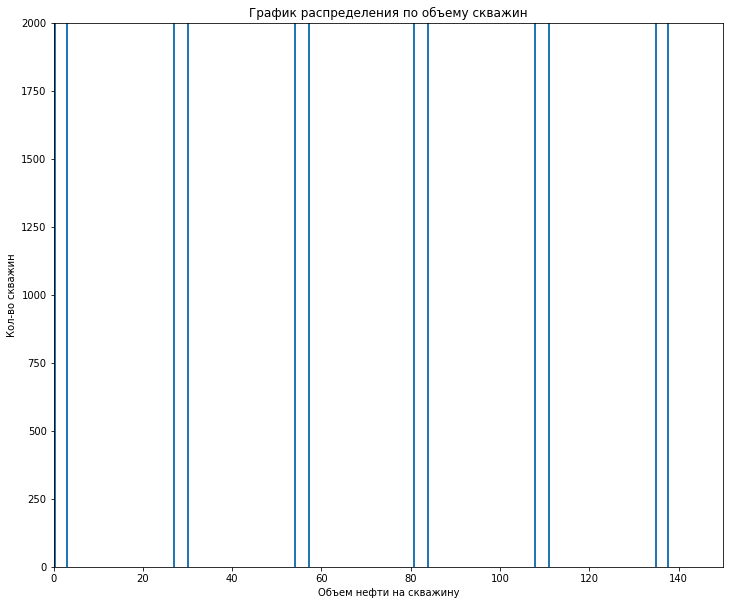

In [ ]:
product_oil(oil_2['product'], 300, 150, 2000)

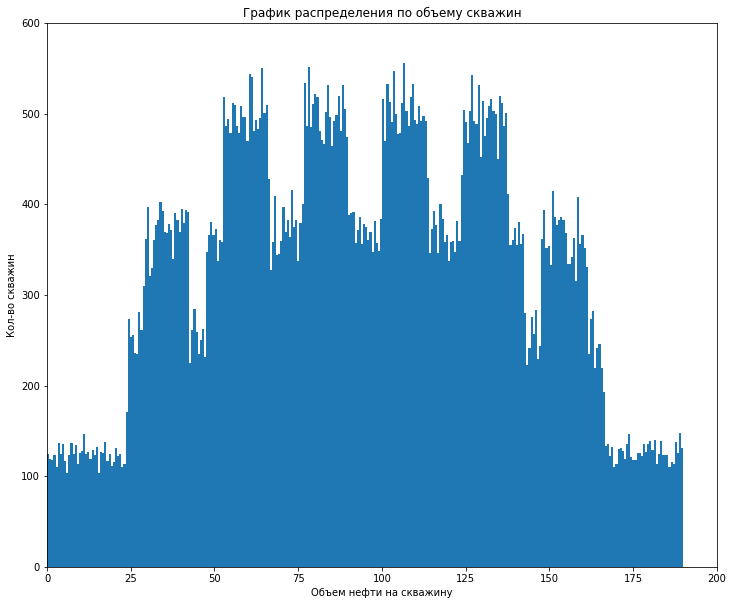

In [ ]:
product_oil(oil_3['product'], 300, 200, 600)

In [ ]:
oil_2['product'].value_counts()

53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: product, dtype: int64

### Вывод по первой главе

В первой главе мы загрузили данные из трех регионов, проверили на пропуски, избавились от дубликатов. 

Для каждого региона создали корреляционную матрицу, в котором обнаружили, что есть почти 100 % зависимость во втором регионе между одним из факторов и целевым признаком.

Нарисовали гистограмму для кажого региона. 
По гистограммам можно понять, что опять же во втором регионе данные имеют странное распределение: распределение объема с промежутком по 25. Так распределены равномерно все скважины в данном регионе. Дальше мы посмотрели значения, которыее есть в данном регионе: огромное количество скважин(более 8 тыс) с одинаковым количеством добычи нефти. Это наводит на мысль, что кто то намеренно вносил даные таким способом.  

## Обучение и проверка модели

Разобьем все 3 региона на обучающую и валидационную выборки  в соотношении 75:25. Признаки модели в наших данных -'f0','f1','f2'. Целевой признак - 'product'. Также мы удалим из признаков - id (уникальный идентификатор скважины), так как данные в данном столбце могут исказить обучение.

Для каждого региона мы:
   1) создадим модель
   2) посчитаем средний запас предсказанного сырья 
   3) посчитаем значение RMSE модели

In [ ]:
train_oil_1, valid_oil_1 = train_test_split(oil_1, test_size=0.25, random_state=42)
train_oil_2, valid_oil_2 = train_test_split(oil_2, test_size=0.25, random_state=42)
train_oil_3, valid_oil_3 = train_test_split(oil_3, test_size=0.25, random_state=42)

train_f1_oil = train_oil_1.drop(['product', 'id'], axis=1)
train_t1_oil = train_oil_1['product']
valid_f1_oil = valid_oil_1.drop(['product', 'id'], axis=1)
valid_t1_oil = valid_oil_1['product']

train_f2_oil = train_oil_2.drop(['product', 'id'], axis=1)
train_t2_oil = train_oil_2['product']
valid_f2_oil = valid_oil_2.drop(['product', 'id'], axis=1)
valid_t2_oil = valid_oil_2['product']

train_f3_oil = train_oil_3.drop(['product', 'id'], axis=1)
train_t3_oil = train_oil_3['product']
valid_f3_oil = valid_oil_3.drop(['product', 'id'], axis=1)
valid_t3_oil = valid_oil_3['product']

In [ ]:
model = LinearRegression()
model_1 = model.fit(train_f1_oil, train_t1_oil)
predicted_oil_1 = model_1.predict(valid_f1_oil)
predicted_mean_1 = predicted_oil_1.mean()
mean_squared_error_1 = mean_squared_error(valid_t1_oil, predicted_oil_1)**0.5

model_2 = model.fit(train_f2_oil, train_t2_oil)
predicted_oil_2 = model_2.predict(valid_f2_oil)
predicted_mean_2 = predicted_oil_2.mean()
mean_squared_error_2 = mean_squared_error(valid_t2_oil, predicted_oil_2)**0.5

model_3 = model.fit(train_f3_oil, train_t3_oil)
predicted_oil_3 = model_3.predict(valid_f3_oil)
predicted_mean_3 = predicted_oil_3.mean()
mean_squared_error_3 = mean_squared_error(valid_t3_oil, predicted_oil_3)**0.5

Ниже создадим таблицу и график, в которых можно будет сравнить данные во всех регионах 

In [ ]:
table = {'Регион 1':np.array([predicted_mean_1.round(2),mean_squared_error_1.round(2)]),
           'Регион 2':np.array([predicted_mean_2.round(2),mean_squared_error_2.round(2)]),
           'Регион 3':np.array([predicted_mean_3.round(2),mean_squared_error_3.round(2)])}
new_table = pd.DataFrame(table, index=['Средний запас предсказанного сырья','Значение RMSE'])
new_table

,Регион 1,Регион 2,Регион 3
Средний запас предсказанного сырья,92.40,68.71,94.77
Значение RMSE,37.76,0.89,40.15


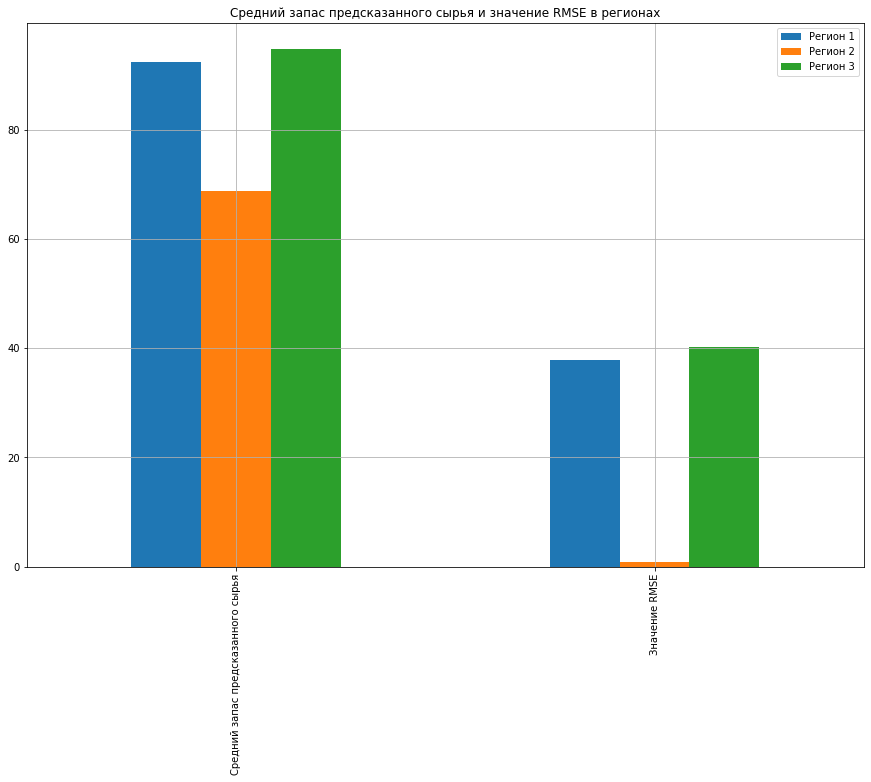

In [ ]:
new_table.plot(
    kind='bar', figsize=(15,10), grid=True,
    title='Средний запас предсказанного сырья и значение RMSE в регионах'
    )

plt.show()

### Вывод по второй главе

С помощью модели линейной регрессии мы оценили возможный средний запас предсказанного сырья в каждом из регионов. Здесь опять мы выделяем второй регион: RMSE меньше 1 (среднеквадратичная ошибка -это  мера различий между значениями предсказанными моделью и наблюдаемыми значениями). Здесь необходимо вспомнить про зависимость между факторами во втором регионе. Возможно "шаговые" данные из второго региона сказались на модели и она достаточно сильно переобучилась.
В то же время средний запас предсказанного сырья во втором регионе оказался меньше всех.
По показателям 1 и 3 регион почти не отличаются.
Не будем пока сбрасывать со счетов второй регион, дальше нам будет неободимо оценить прибыльность и риски каждого из регионов

## Подготовка к расчёту прибыли

Для дальнейших рассчетов сохраним все ключевые данные в отдельных переменных. 

In [ ]:
INC_PER_PRODUCT = 450000 # доход с каждой единицы продукта 
BUDG_REG = 10000000000 # бюджет в регионе
BEST_US = 200 # количество лучших шахт для расчета прибыли

Всего в одном регионе бюджет в 10 млрд.руб. выделяют для разработки 200 наиболее перспективных скважин.
Точка безубыточности считается следующим образом: бюджет делим на доход с каждой единицы продукта. Для того, чтобы найти средний объем нефти в скважине для безубыточного функционирования поделим на количество лучших точек для разработки 

In [ ]:
PROF = BUDG_REG / INC_PER_PRODUCT

In [ ]:
last_profit = PROF / BEST_US
print ("Средний объем нефти в скважине для безубыточного функционирования", np.ceil(last_profit))

Средний объем нефти в скважине для безубыточного функционирования 112.0


In [ ]:
new_table.iloc[0:1]

,Регион 1,Регион 2,Регион 3
Средний запас предсказанного сырья,92.4,68.71,94.77


### Вывод по третьей главе

При уровне цен в 450 000 руб. за тыс.баррелей, безубыточная добыча достигается только если в скважинах есть запас в 112 тыс.баррелей. По предсказаниям модели в среднем такого объема нет ни в одном регионе. Перейдем к рассчету прибыли и рисков.

## Расчёт прибыли и рисков 

In [ ]:
example1 = pd.Series(predicted_oil_1).reset_index(drop=True)
example2 = pd.Series(valid_t1_oil).reset_index(drop=True)
predictions_i = example1.sort_values(ascending=False)[:BEST_US].index
selected_i = example2[predictions_i]
revenue_example = selected_i.sum() * INC_PER_PRODUCT - BUDG_REG
revenue_example

3359141114.462179

Первый регион рассчитал вручную, дальше решил попробовать через формулу. Для начала нам будет необходимо перевести переменные  predicted_oil (предсказания модели) и valid_t_oil (валидационная выборка, целевой признак 'product') в таблицы.  Далее мы сортируем данные с предсказаниями, и выбираем 200 лучших точек. Далее умножаем сумму баррелей на доход с каждой единицы продукта, отнимаем сумму бюджета в регионе и получаем прибыль. Далле пропишем функцию для расчета прибыли по выбранным скважинам, проверим правильно ли рассчитали по первому региону.

In [ ]:
def profit(target, predictions):
    target = pd.Series(target).reset_index(drop=True)
    predictions = pd.Series(predictions).reset_index(drop=True)
    predictions_s = predictions.sort_values(ascending=False)[:BEST_US].index
    selected = target[predictions_s]
    revenue = selected.sum() * INC_PER_PRODUCT - BUDG_REG
    return round(revenue, 1)

In [ ]:
profit(valid_t1_oil, predicted_oil_1)

3359141114.5

In [ ]:
profit(valid_t2_oil, predicted_oil_2)

2415086696.7

In [ ]:
profit(valid_t3_oil, predicted_oil_3)

2598571759.4

Здесь я решил создать две функции, которые помогут нам проверить риски и распределение прибыли. "bootstrap_2" - функция, которая на вход получает: целевой признак валидационной выборки, предсказания модели, количество повторений(1000) и размер выборки(500, для разведки региона). Выводить данная функция будет: среднюю выручку в регионе, риск убытков (в том случае, если показатели прибыли меньше нуля), 95%-й доверительный интервал, верхний и нижний уровни.

Функция "bootstrap_3" покажет нам 95 %ый доверительный интервал по распределению Стьюдента. Мне показалось, что такое распределение тоже можно использовать в задаче, пропишем это также в нашей инальной таблице.

После этого рассчитаем по формулам все 3 региона.

In [ ]:
def bootstrap_2(target, probabilities, iterations, sample_size):
    state = np.random.RandomState(42)
    values = []
    for i in range(iterations):
        target_subsample = target.sample(n=sample_size, random_state=state, replace=True)
        probs_subsample = probabilities[target_subsample.index]
        values.append(profit(target_subsample, probs_subsample))

    values = pd.Series(values)
    mean = values.mean()
    risk = (values < 0).mean()
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    quantile_interval = (lower, upper)
    return round(mean,2), round(risk*100, 2), quantile_interval, lower, upper

In [ ]:
oil_1_mean, oil_1_risk, oil_1_quantile, down_1, up_1 = bootstrap_2(
    valid_t1_oil.reset_index(drop=True), predicted_oil_1, 1000, 500
    )

In [ ]:
oil_2_mean, oil_2_risk, oil_2_quantile, down_2, up_2 = bootstrap_2(
    valid_t2_oil.reset_index(drop=True), predicted_oil_2, 1000, 500
    )

In [ ]:
oil_3_mean, oil_3_risk, oil_3_quantile, down_3, up_3 = bootstrap_2(
    valid_t3_oil.reset_index(drop=True), predicted_oil_3, 1000, 500
    )

In [ ]:
finalle = {'Регион 1':np.array([oil_1_mean / 1000 , oil_1_risk, down_1.round(2), up_1.round(2)]),
           'Регион 2':np.array([oil_2_mean / 1000, oil_2_risk, down_2.round(2), up_2.round(2)]),
           'Регион 3':np.array([oil_3_mean / 1000, oil_3_risk, down_3.round(2), up_3.round(2)])}
final_table = pd.DataFrame(finalle, index=['Регион средняя выручка (в тыс)', 
                                             'Риск убытков', 'Нижний интервал',
                                            'Верхний интервал по квантилям'])
final_table

,Регион 1,Регион 2,Регион 3
Регион средняя выручка (в тыс),3.995755e+05,4.520489e+05,3.750099e+05
Риск убытков,6.000000e+00,1.500000e+00,8.000000e+00
Нижний интервал,-1.104679e+08,6.168448e+07,-1.447667e+08
Верхний интервал по квантилям,8.974603e+08,8.453402e+08,8.883904e+08


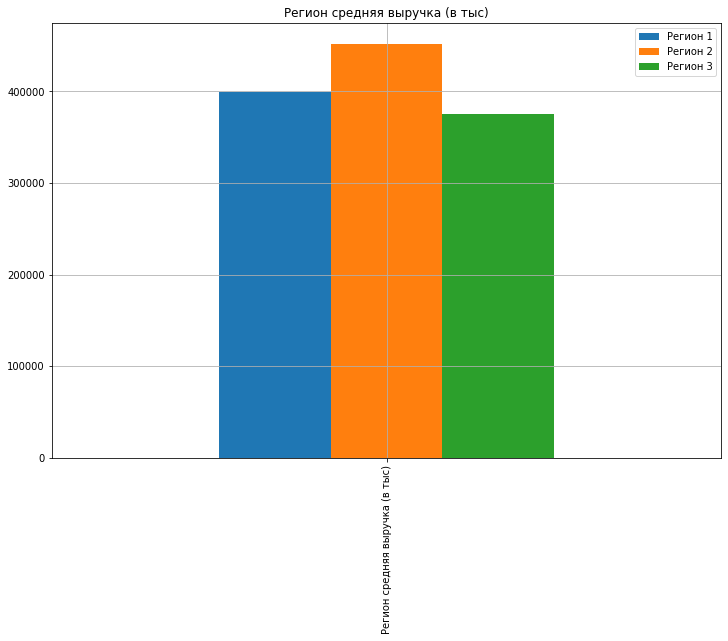

In [ ]:
region_mean = final_table.iloc[0:1]
region_mean.plot(
    kind='bar', figsize=(12,8), grid=True, title='Регион средняя выручка (в тыс)'
    )

plt.show()

### Вывод по четвертой главе

Итак, когда все данные у нас есть, необходимо выбрать самый лучший регион. Несмотря на то, что мы "сомневались" во втором региона, по показателям он оказался лучше всех. У данного региона вероятность убытков всего 1% и в пределах доверительного интервала 95% добыча все равно остаётся безубыточной. Кроме того, несмотря на то, что предсказанное значение добычи ниже чем в других регионах средняя прибыль самая высокая.

## Общий вывод

1. В начале мы провели исследовательский анализ данных, проверили датасеты на наличие пропусков, удалили дупликаты. Также мы проверили зависимость между факторами и целевым признаком в таблицах. Обратили внимание на второй регион, где зависимость между двумя признаками была максимальна.
2. Построили модель линейной регрессии, для предсказания объемов нефти в скважинах в каждом из регионов. Из - за высокой зависимости среднеквадратичная ошибка во втром регионе оказалась меньше 1.
3. Определили ключевые значения в регионах, построили графики с объемом продукта в каждом регионе. Во втором регионе увидели "странное" распределение объема продукта в каждой скважине ("шаговое")
3. Создали функцию для рассчета прибыли, затем мы выполнили процедуру бутстрепа, нашли 95% доверительный интервал для среднего объема нефти в скважинах. По итогам исследования, наиболее перспективным для разработки оказался второй регион. Риски убытков в данном регионе стремятся к 0, а средняя прибыль больше чем в остальных регионах.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован